# Run

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/S10/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/S10


##  Install Requirements

In [2]:
!pip install torchsummary
!pip install torch_lr_finder

## Device Configuration

In [3]:
import torch
# Device configuration -use CUDA tensor types if available
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
print("CUDA Available?", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

CUDA Available? True


##  Transform and load the data

In [4]:
#get the transforms, the data and then load the data
from transform import get_a_train_transform, get_a_test_transform
from dataset import Cifar10Dataset, get_loader

train_transform = get_a_train_transform()
test_transform = get_a_test_transform()

train_data = Cifar10Dataset(root='../data', train=True, download=True, transforms=train_transform)
test_data = Cifar10Dataset(root='../data', train=False, download=True, transforms=test_transform)

batch_size=512
train_loader, test_loader = get_loader(train_data, test_data, batch_size=batch_size, use_cuda=True)

#mapping the index to respective classes
class_map = {
    0: 'plane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Files already downloaded and verified
Files already downloaded and verified


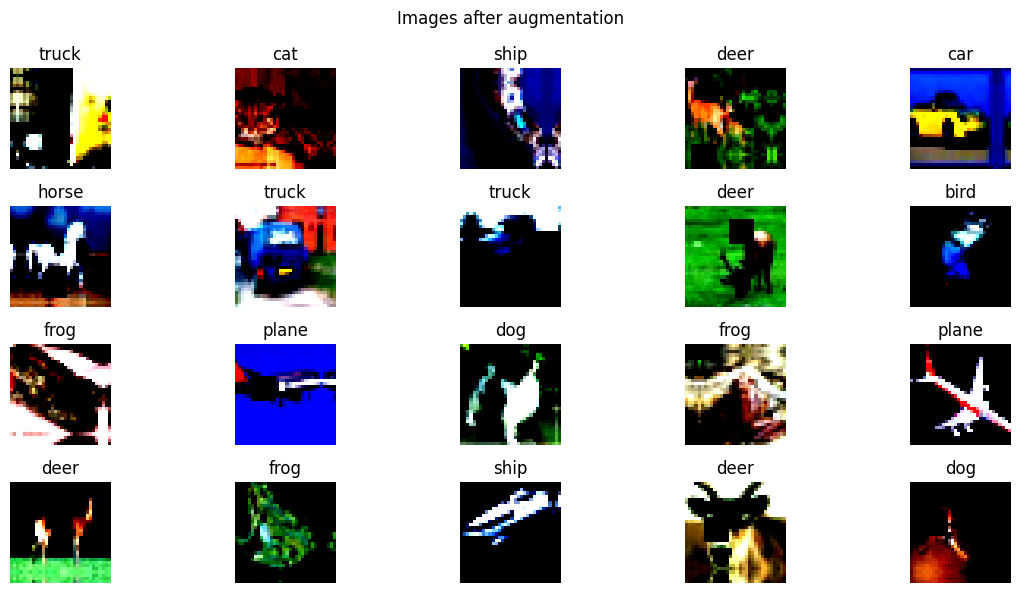

In [13]:
#visualize the data after augmentation
from utils import visualize_augmentations
data, label = next(iter(train_loader))
visualize_augmentations(data, label, 'Images after augmentation', class_map, samples=20, cols=5)

##  Get the model

In [5]:
# get the model
from model import CustomNet
import torch.nn as nn
import torch.optim as optim

model = CustomNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

## LR Finder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.22E-02


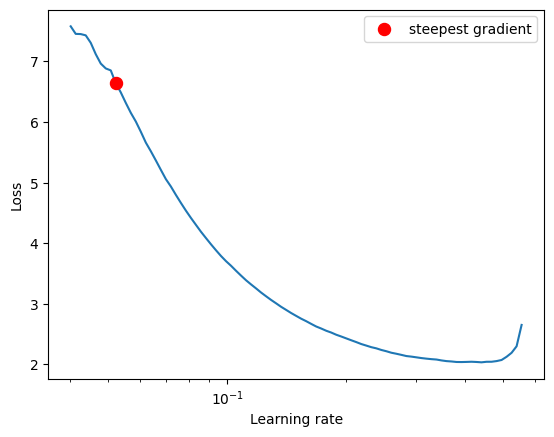

In [6]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

##  Train the model

In [7]:
from train_test import *
from utils import print_epoch_progress

# variables to store accuracy and loss for plotting graphs for model later
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
lr_plt = []

num_epochs = 24
scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr= 5.22E-02,  #5.70E-02,   #4.79E-02
        steps_per_epoch=len(train_loader),
        epochs=num_epochs,
        pct_start=0.2,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )


print(f'| Epoch | {"LR":8} | TrainAcc  | TrainLoss | TestAcc   | TestLoss |')

for epoch in range(1, num_epochs+1):
  train_acc, train_loss = train_model(model, device, train_loader, optimizer, criterion,scheduler)
  train_accuracy.append(train_acc)
  train_losses.append(train_loss)
  test_acc, test_loss = test_model(model, device, test_loader, criterion)
  test_accuracy.append(test_acc)
  test_losses.append(test_loss)
  lr = scheduler.get_last_lr()[0]
  lr_plt.append(lr)
  print_epoch_progress(epoch, lr, train_acc, train_loss, test_acc, test_loss)


| Epoch | LR       | TrainAcc  | TrainLoss | TestAcc   | TestLoss |
|     1 | 0.011311 | 48.516  % | 1.477044  | 52.35   % | 0.002915 |
|     2 | 0.0221   | 62.162  % | 1.107503  | 68.59   % | 0.001872 |
|     3 | 0.03289  | 70.036  % | 0.873667  | 73.09   % | 0.001615 |
|     4 | 0.043679 | 74.302  % | 0.74501   | 72.99   % | 0.001592 |
|     5 | 0.051629 | 74.354  % | 0.739382  | 74.31   % | 0.001502 |
|     6 | 0.04891  | 75.292  % | 0.715022  | 72.61   % | 0.00158  |
|     7 | 0.046192 | 76.394  % | 0.68299   | 74.7    % | 0.001491 |
|     8 | 0.043473 | 76.492  % | 0.675827  | 76.58   % | 0.001353 |
|     9 | 0.040755 | 76.908  % | 0.660704  | 69.81   % | 0.00196  |
|    10 | 0.038036 | 77.984  % | 0.63577   | 77.14   % | 0.001325 |
|    11 | 0.035318 | 78.348  % | 0.626188  | 74.45   % | 0.001468 |
|    12 | 0.032599 | 78.372  % | 0.62245   | 69.74   % | 0.00188  |
|    13 | 0.029881 | 78.852  % | 0.605899  | 79.68   % | 0.001182 |
|    14 | 0.027162 | 79.764  % | 0.586508  | 78.

## LR plot

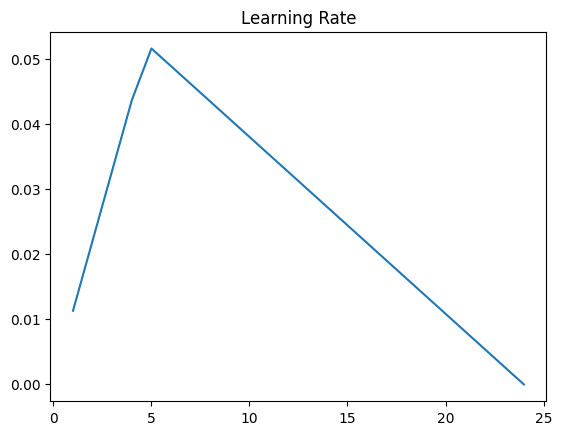

In [8]:
import matplotlib.pyplot as plt
epochs = range(1,25)
plt.plot(epochs,lr_plt)
plt.title("Learning Rate")
plt.show()



##  Accuracy and Loss

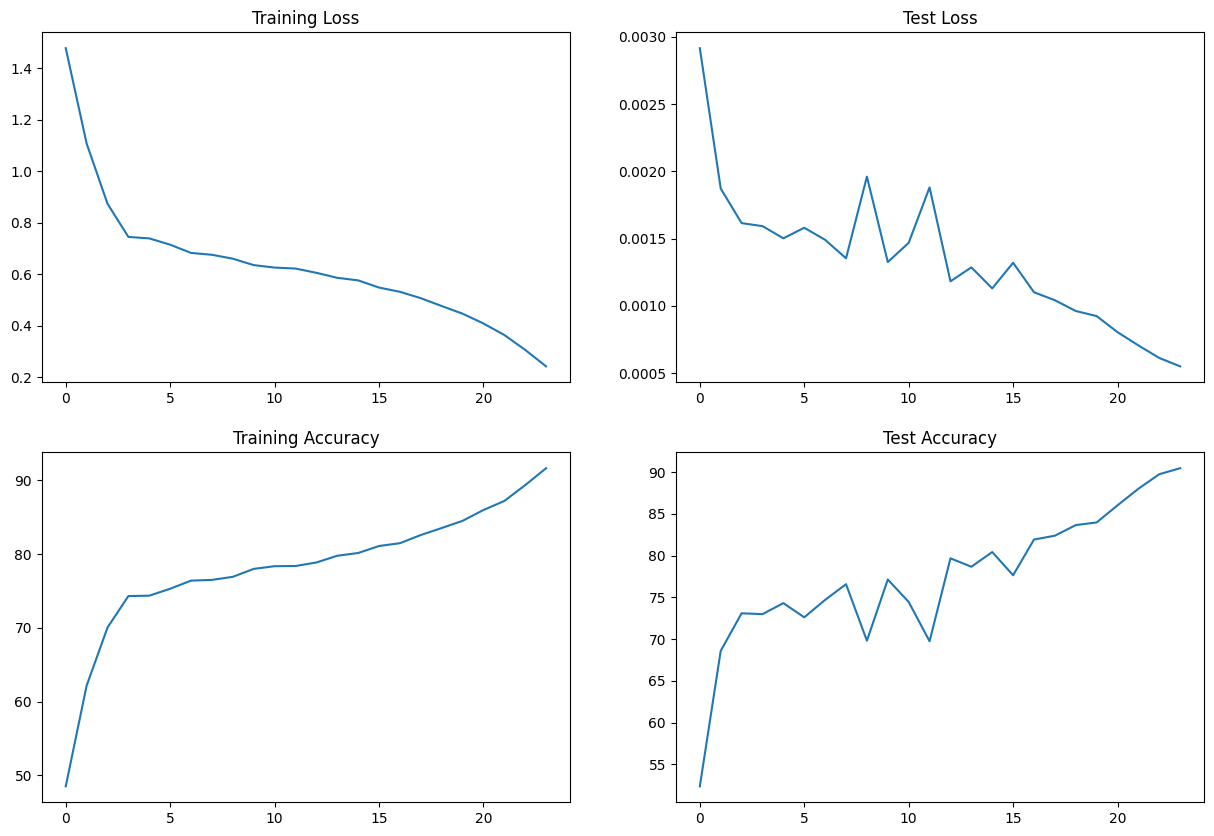

In [9]:

from utils import plot_loss_accuracy
plot_loss_accuracy(train_losses, test_losses, train_accuracy, test_accuracy)


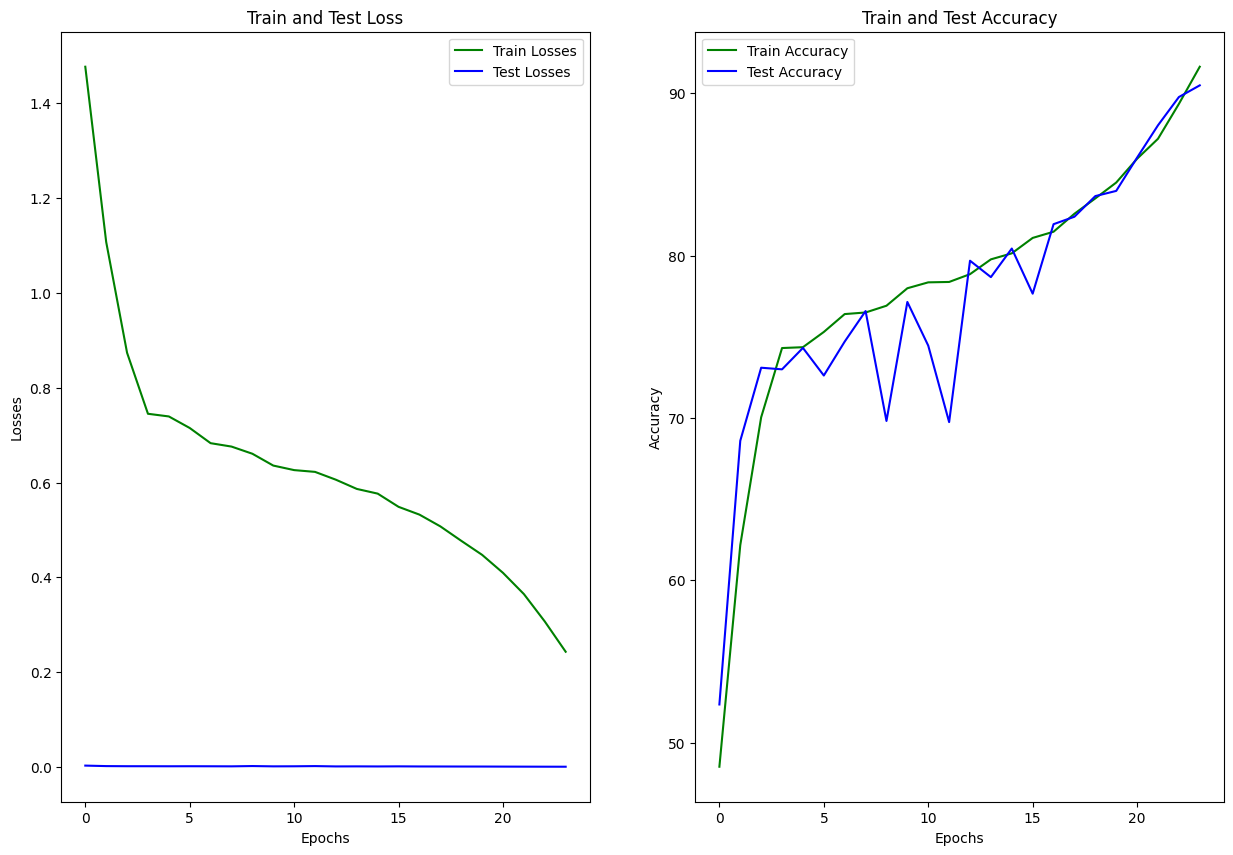

In [10]:
from utils import overplot_loss_accuracy
overplot_loss_accuracy(train_losses, test_losses, train_accuracy, test_accuracy)


Total Incorrect Predictions 952


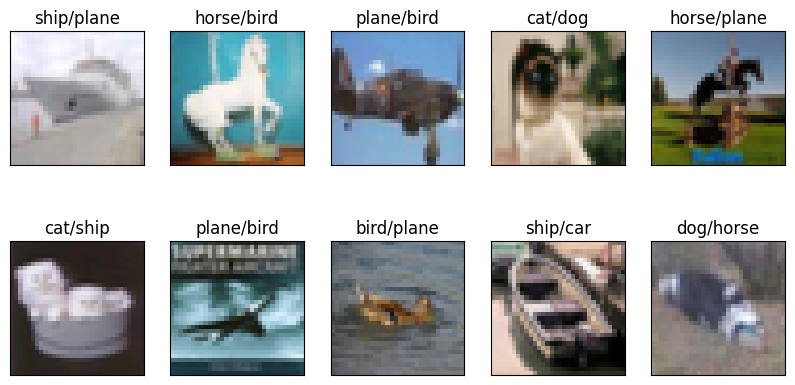

In [11]:
from utils import get_incorrrect_predictions, plot_incorrect_predictions
incorrect_prdeictions = get_incorrrect_predictions(model, test_loader, device, criterion)
plot_incorrect_predictions(incorrect_prdeictions, class_map, 10)

##  Summary

In [12]:
#print model summary
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,